## Introduction

This code creates a forecast model to understand the price of avocados. There is one data source that have been used, a csv file. Using CRISP DM framework (Schroer et al., 2021) to structure this project.

The code is split into 6 sections:

1.   Data Description and Load
2.   Data Cleanse
3.   Exploratory Data Analysis (EDA)
4.   Modelling
5.   Findings and Recommendations
6.   References

Created: January 2024

**Student Number: BP0279765**

## 1. Data Description and Load

### Data Description

There are 14 variables in this dataset:
* 2 categorical variables,
* 10 continuous variables,
* 1 variable contains date of observation, and
* 1 variable as index of dataset.

The following is the structure of the dataset:

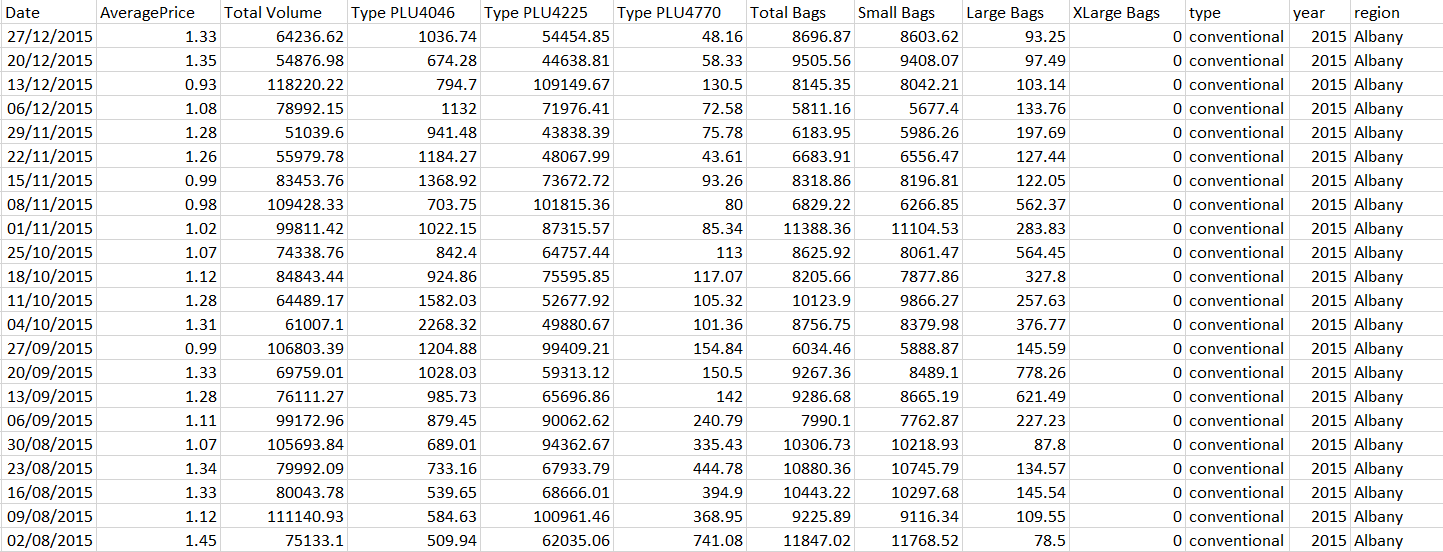


### 1.1 Import Libraries

In [1]:
#Load required libraries   
#Data processing, csv file (e.g. pd.csv) 
import pandas as pd
# support with data structures and perform calculations
import numpy as np

#Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as px
import sweetviz as sv

#to support with errors in code
import warnings 
warnings.filterwarnings('ignore')

#to support with outliers detection and reducing their impact
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

#Modelling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#libraries to support evalutation of model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### 1.2 Load Data

In [2]:
#Create the dataframe from csv, used skipinitialspace to avoid white space
df = pd.read_csv('avocado_data.csv', index_col=0, skipinitialspace = True)

In [3]:
#Check length
print ('avocado_data.csv contains', len(df), 'rows')

avocado_data.csv contains 18249 rows


In [4]:
#Checking the shape by looking at the number of rows/columns
print('The shape of the csv file is (rows, columns):', df.shape)

The shape of the csv file is (rows, columns): (18249, 13)


## 2. Data Cleanse

* Check for missing values
* Check data types
* Check for and analyse duplicates
* Remove Duplicates
* Encode data
* Feature Engineering

### 2.1 Missing Values

In [5]:
#View any cell in the dataframe with a NaN value
df[df.isna().any(axis=1)]

,Date,AveragePrice,Total Volume,Type PLU4046,Type PLU4225,Type PLU4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region


In [6]:
### Check the dataframe for missing data
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
Type PLU4046    0
Type PLU4225    0
Type PLU4770    0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

There are no missing values in the dataset.

### 2.2 Data Types

In [7]:
#Check datatypes
df.dtypes

Date             object
AveragePrice    float64
Total Volume    float64
Type PLU4046    float64
Type PLU4225    float64
Type PLU4770    float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

Date is in the wrong type and will need converting to DateTime

In [8]:
#Change the Date from an object to date type
df[["Date"]] = df[["Date"]].apply(pd.to_datetime)

### 2.3 Duplicates

In [9]:
## Check for duplicates 
df.duplicated(subset=None, keep="first").sum()

0

### 2.4 Encoding

#### Type and Region

In [10]:
#Encoding the categorial variables
encoded_df = df.copy()
features = list(['type', 'region'])
le = LabelEncoder()
for i in features:
    encoded_df[i] = le.fit_transform(encoded_df[i])

### Feature Engineering

Features are different variables in a dataset and creating features enables the understanding of the dataset outside of the current variables. The date will be used to add Day and Month features, as Year is already in the dataset. There will also be mean values added over different time periods. As the modelling will not include a Time Series Analysis the date will then be dropped.

In [11]:
def add_calendar_features(df):
    # this function works out the week and average price by month and year
    return (df.assign(week=lambda df: df['Date'].dt.week,
                                     past_month_mean_y=lambda df: 
                                      (df['AveragePrice'].rolling(window=4)
                                              .mean()
                                              .fillna(method='bfill')),
                                     past_year_mean_y=lambda df: 
                                      (df['AveragePrice'].rolling(window=52)
                                              .mean())
                                              .fillna(method='bfill'))
                              )

ohe = add_calendar_features(encoded_df)

In [13]:
ohe['Month'] = ohe['Date'].dt.month
ohe['Day'] = ohe['Date'].dt.day

ohe = ohe.drop('Date', axis=1)

## 3. EDA

### 3.1 Overview of Dataset

In [14]:
ohe.describe().round(2)

,AveragePrice,Total Volume,Type PLU4046,Type PLU4225,Type PLU4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,week,past_month_mean_y,past_year_mean_y,Month,Day
count,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.0,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00,18249.00
mean,1.41,850644.01,293008.42,295154.57,22839.74,239639.20,182194.69,54338.09,3106.43,0.5,2016.15,26.50,25.92,1.41,1.41,6.37,15.47
std,0.40,3453545.36,1264989.08,1204120.40,107464.07,986242.40,746178.51,243965.96,17692.89,0.5,0.94,15.58,15.34,0.38,0.31,3.53,8.98
min,0.44,84.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2015.00,0.00,1.00,0.52,0.66,1.00,1.00
25%,1.10,10838.58,854.07,3008.78,0.00,5088.64,2849.42,127.47,0.00,0.0,2015.00,13.00,12.00,1.11,1.14,3.00,7.00
50%,1.37,107376.76,8645.30,29061.02,184.99,39743.83,26362.82,2647.71,0.00,0.0,2016.00,26.00,25.00,1.37,1.40,6.00,16.00
75%,1.66,432962.29,111020.20,150206.86,6243.42,110783.37,83337.67,22029.25,132.50,1.0,2017.00,40.00,40.00,1.66,1.64,10.00,23.00
max,3.25,62505646.52,22743616.17,20470572.61,2546439.11,19373134.37,13384586.80,5719096.61,551693.65,1.0,2018.00,53.00,52.00,3.08,2.47,12.00,31.00


                                             |          | [  0%]   00:00 -> (? left)


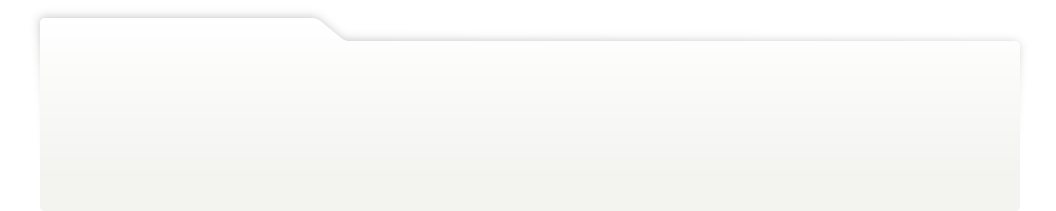
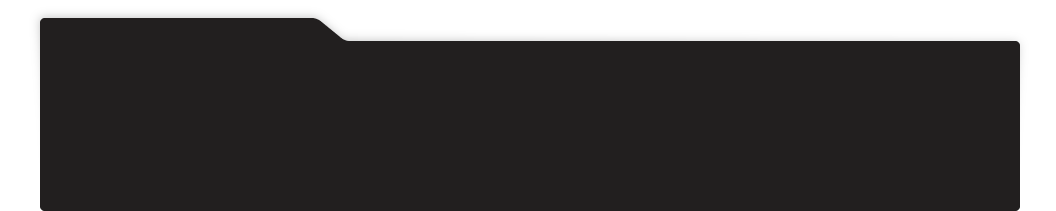
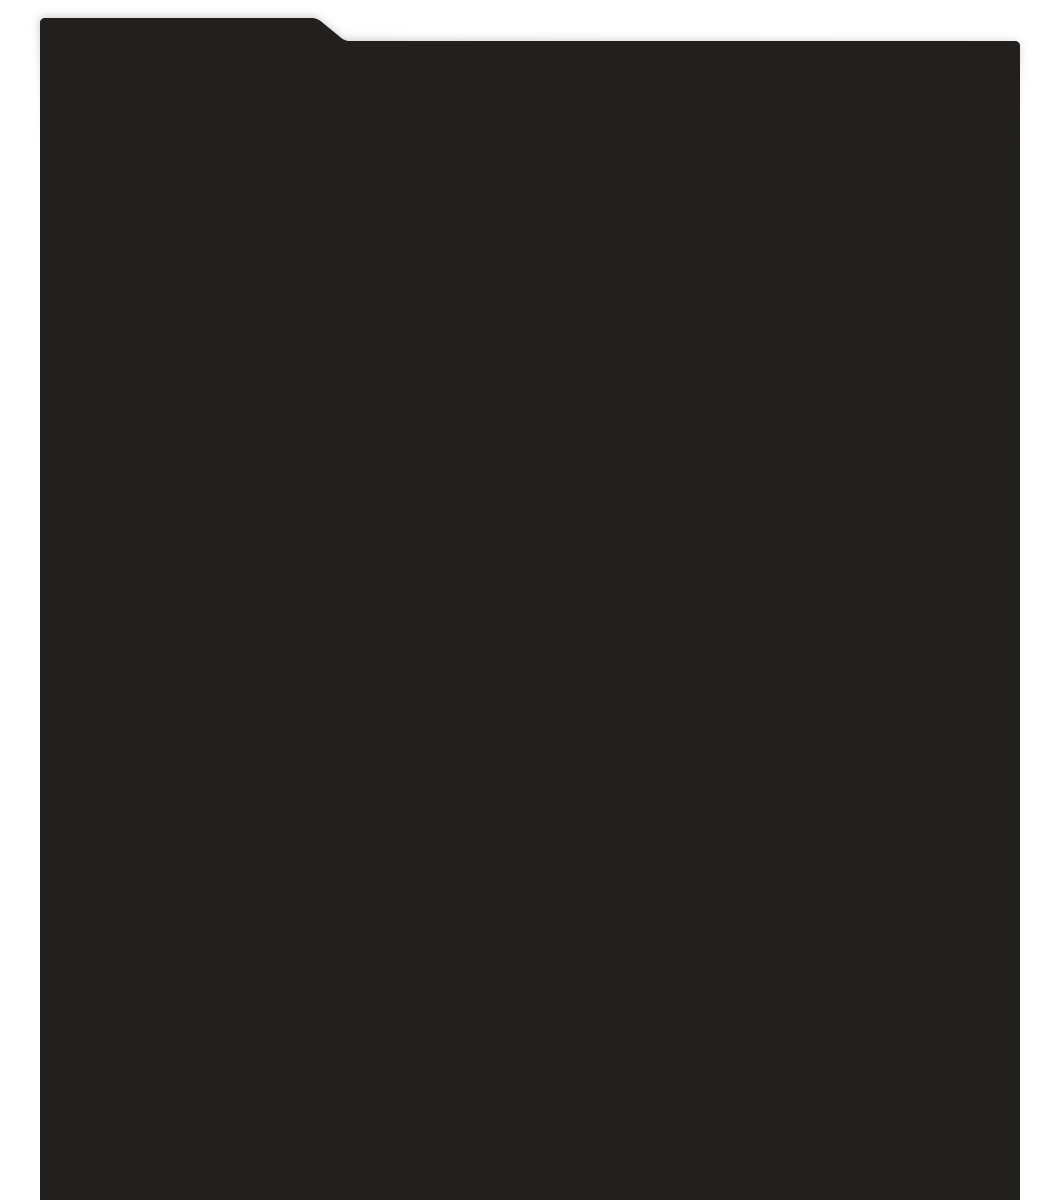
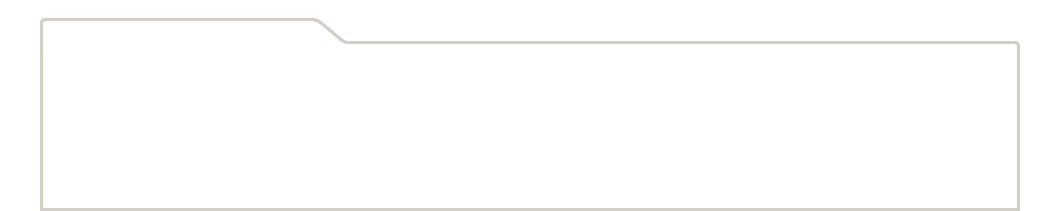
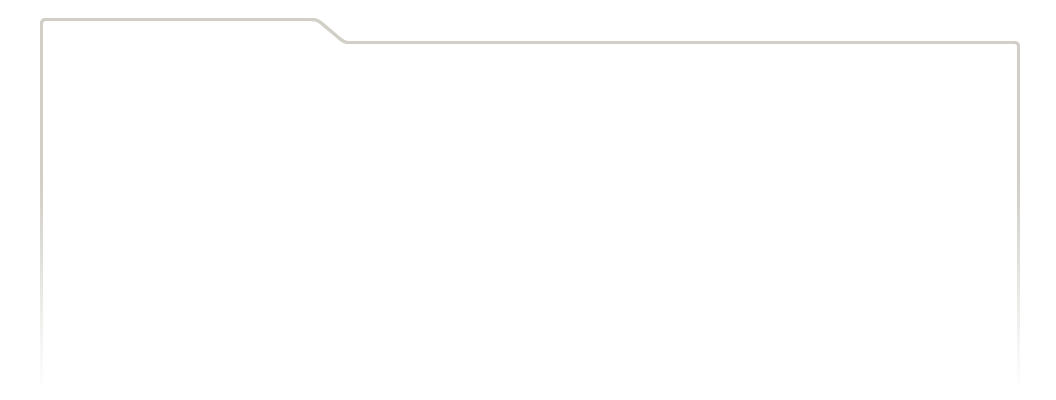
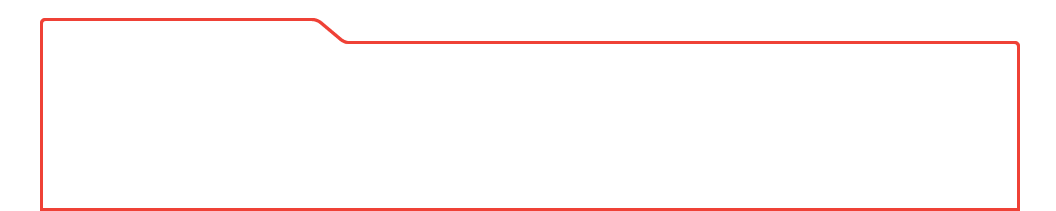
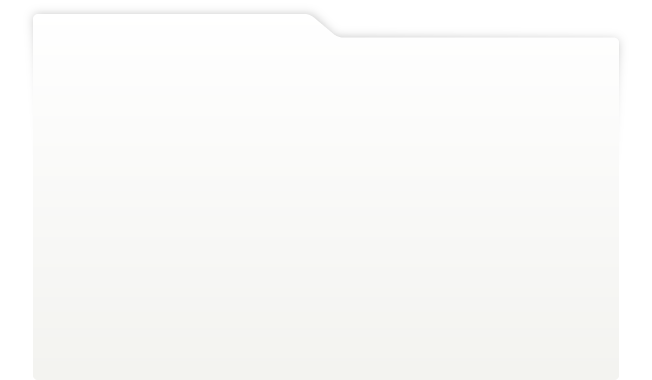
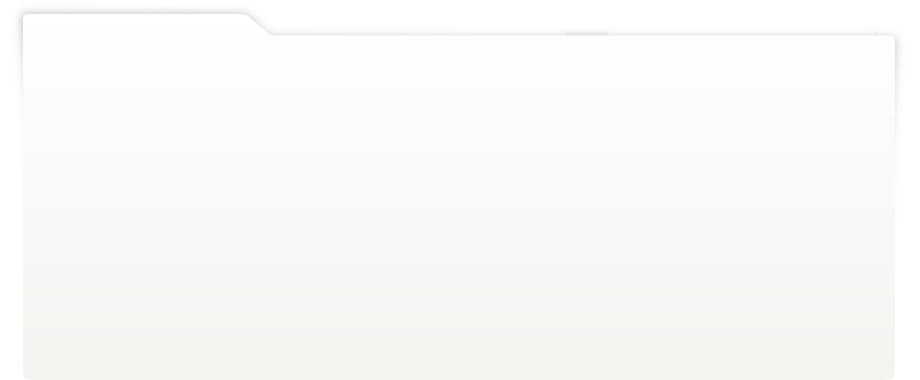
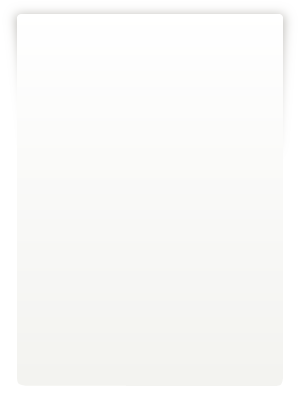
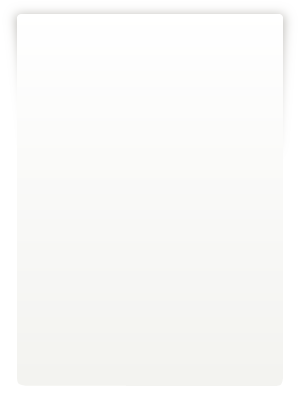
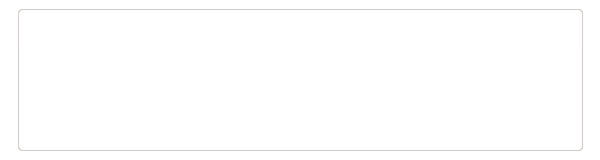
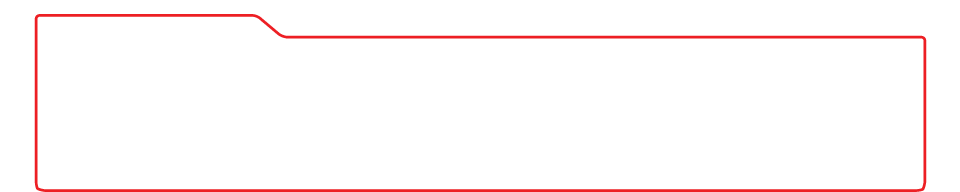
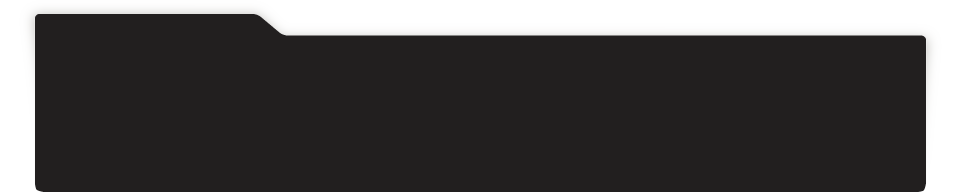
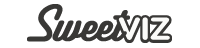
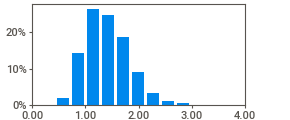
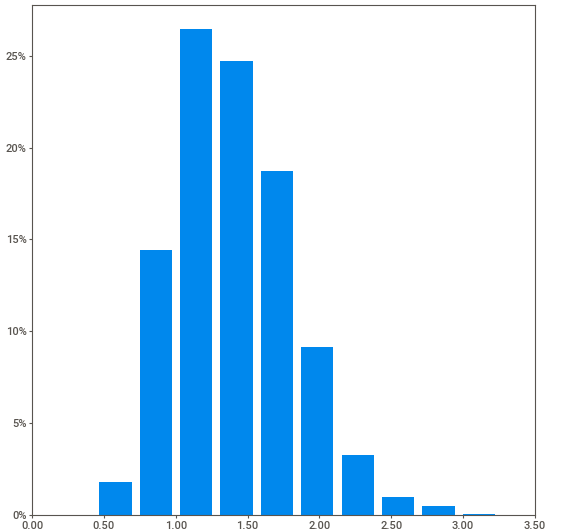
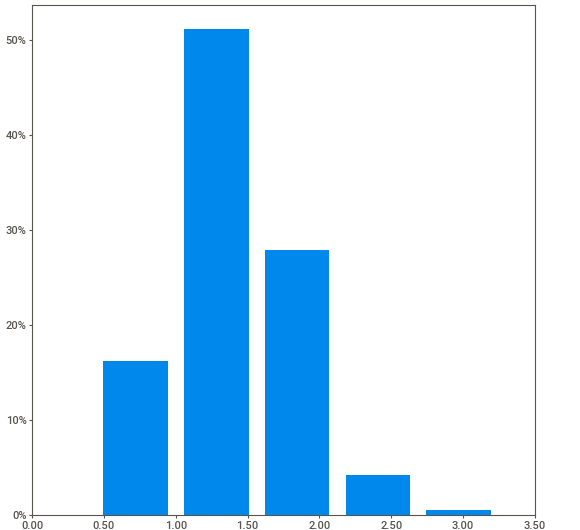
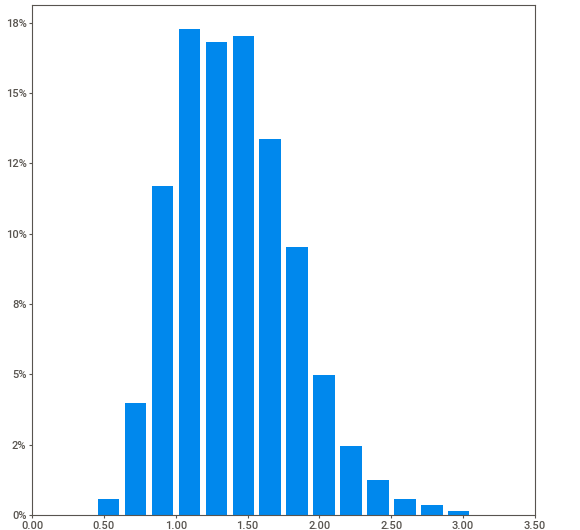
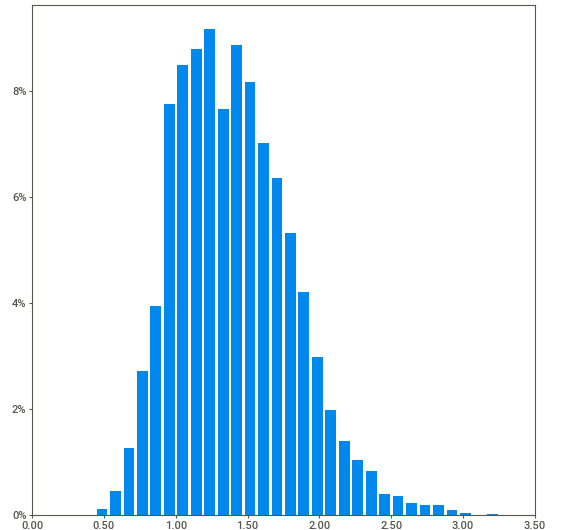
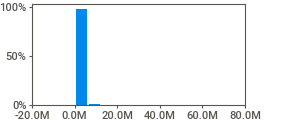
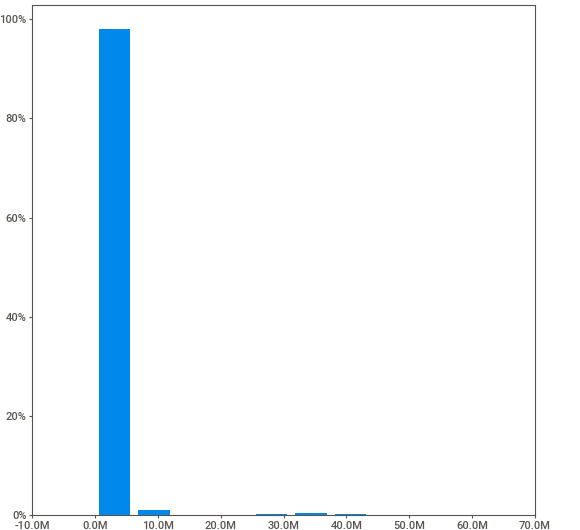
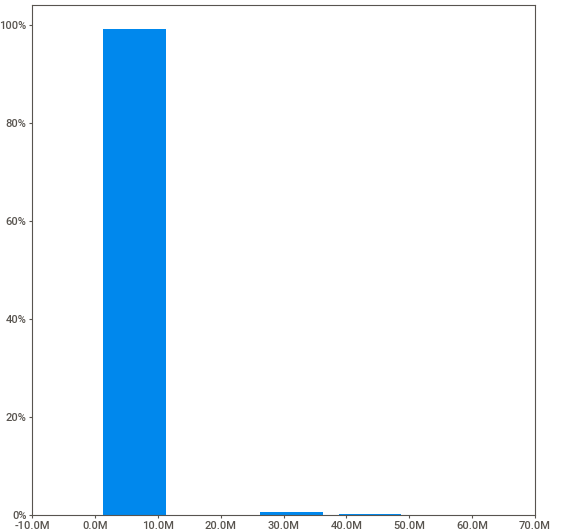
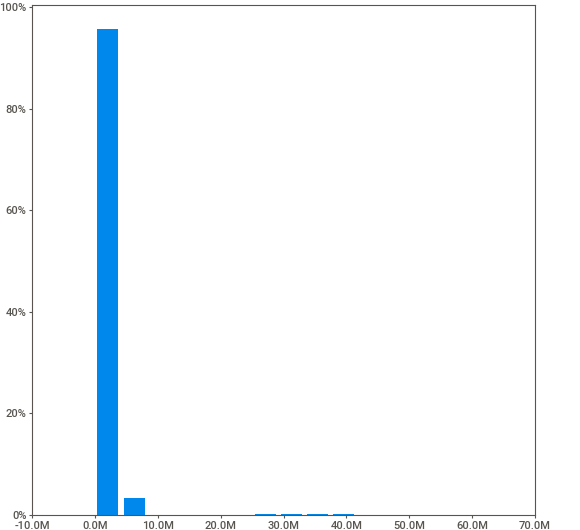
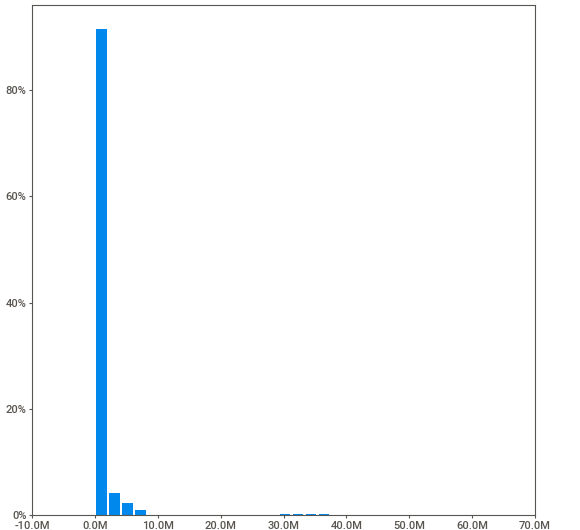
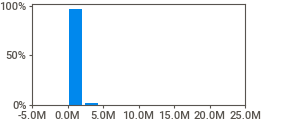
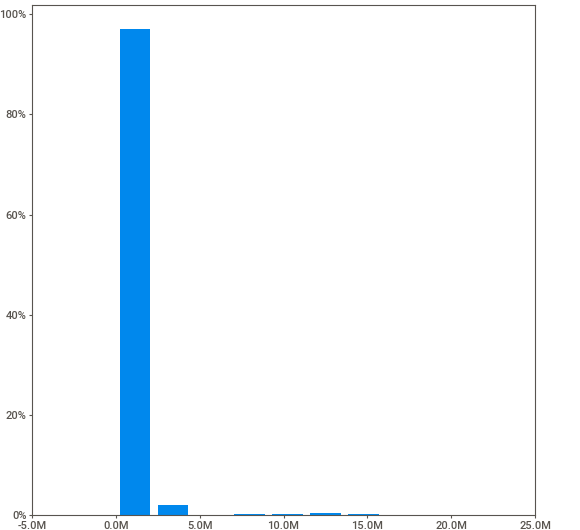
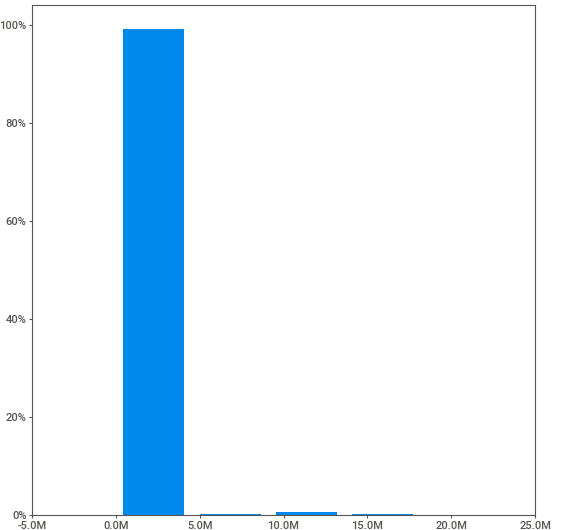
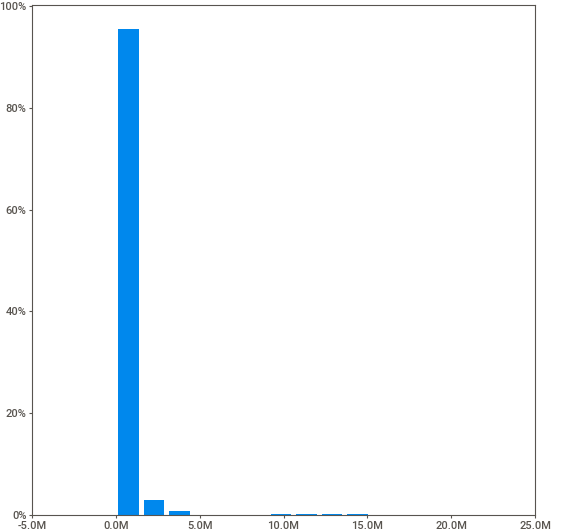
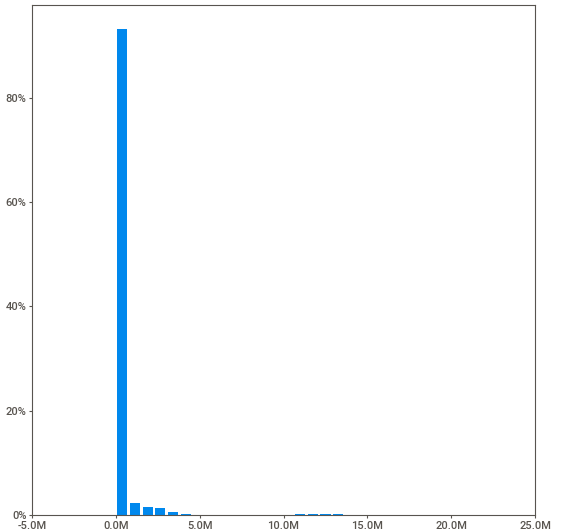
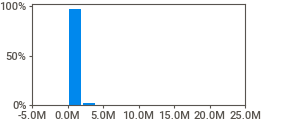
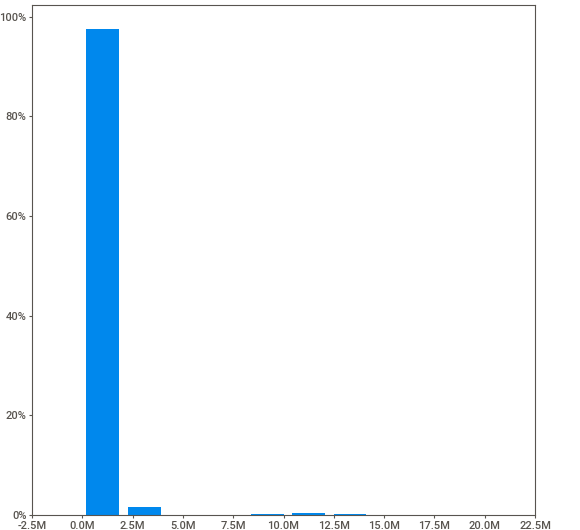
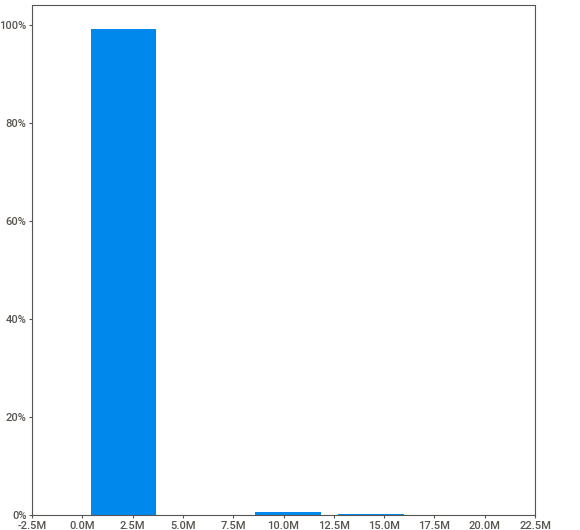
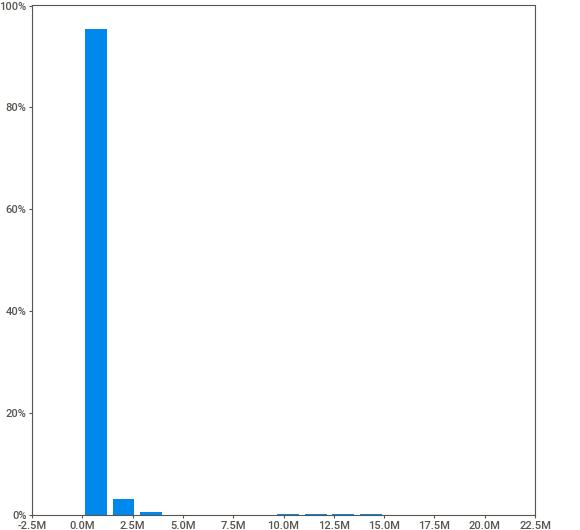
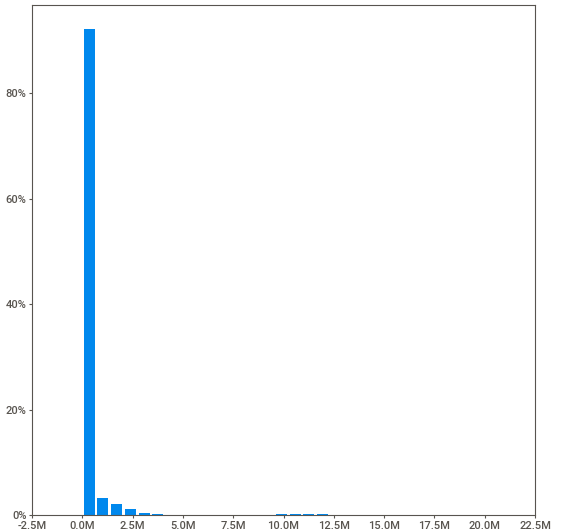
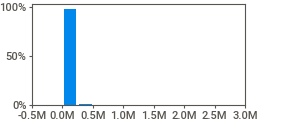
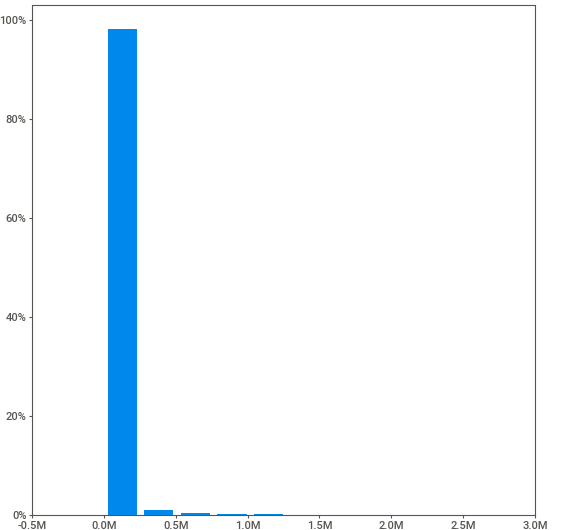
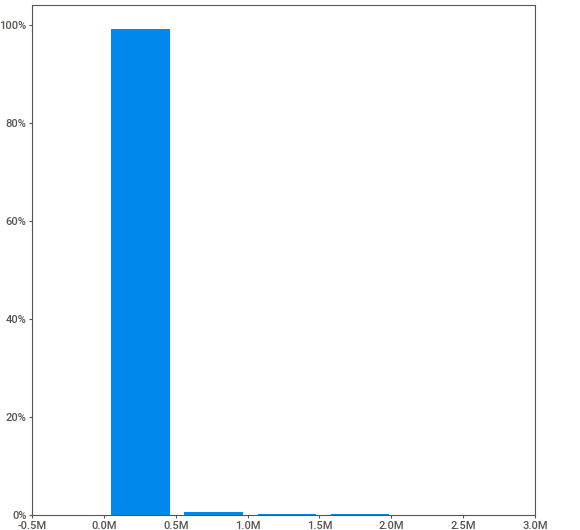
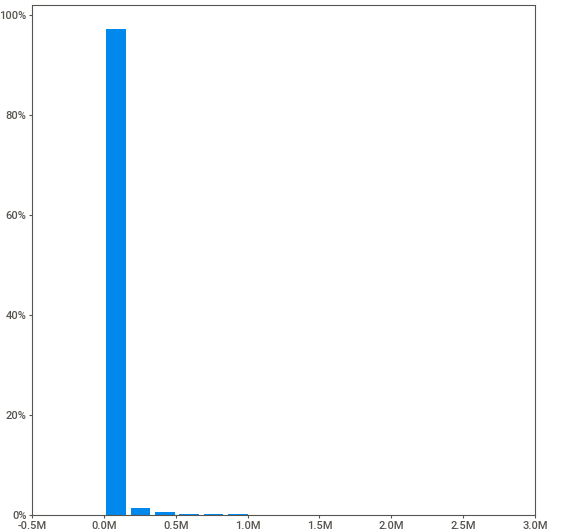
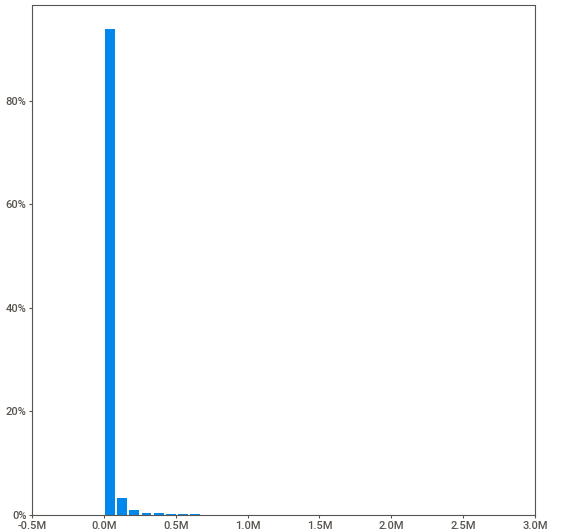
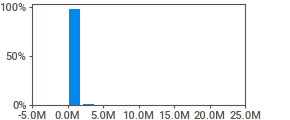
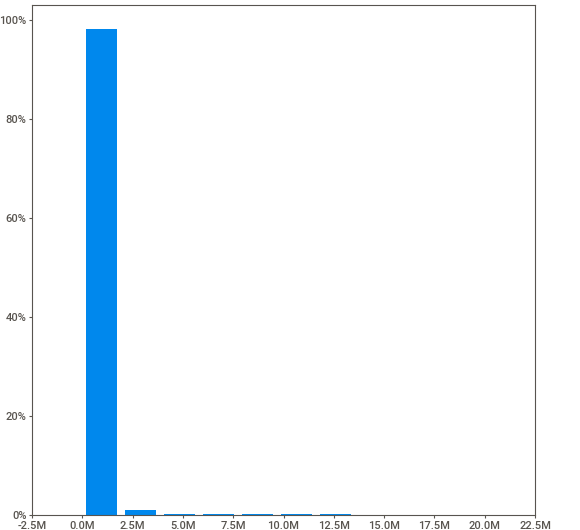
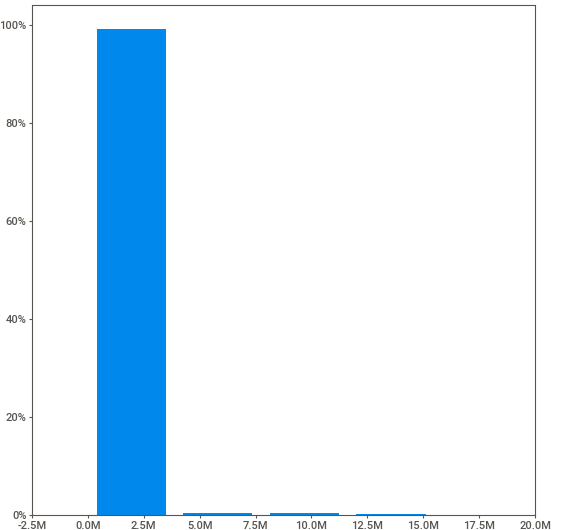
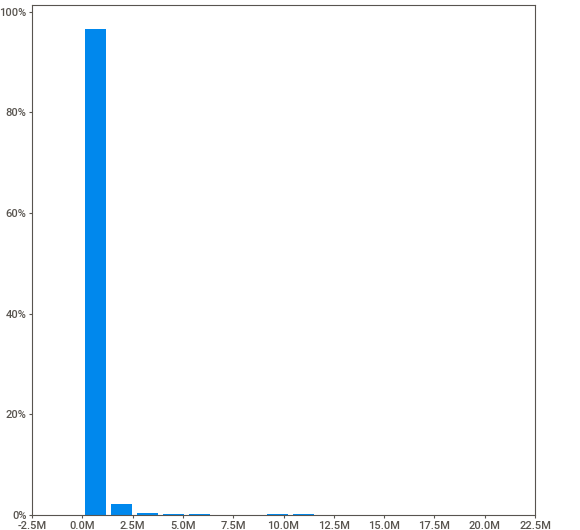
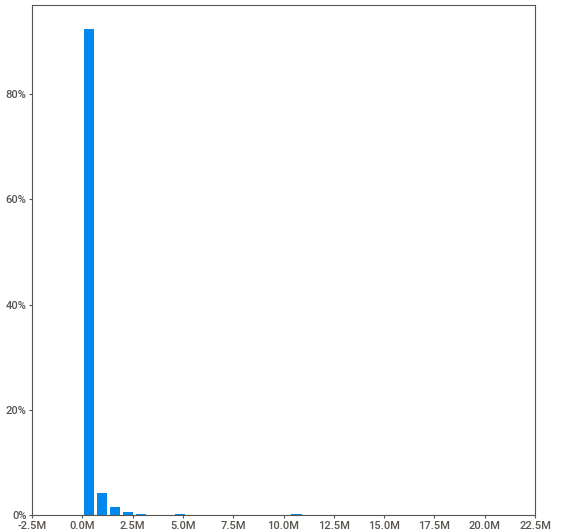
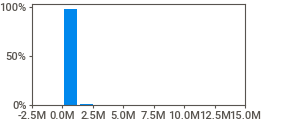
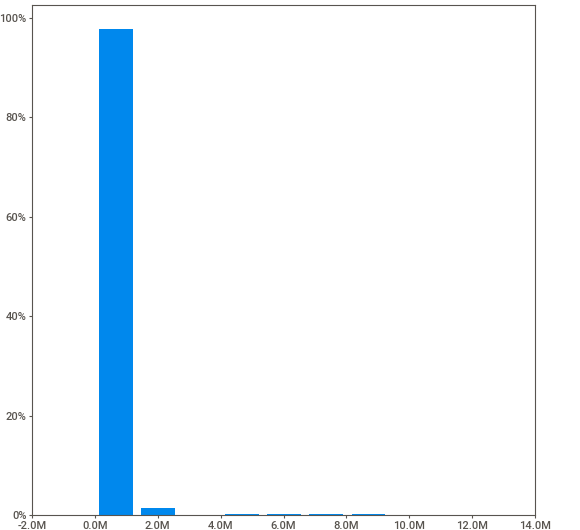
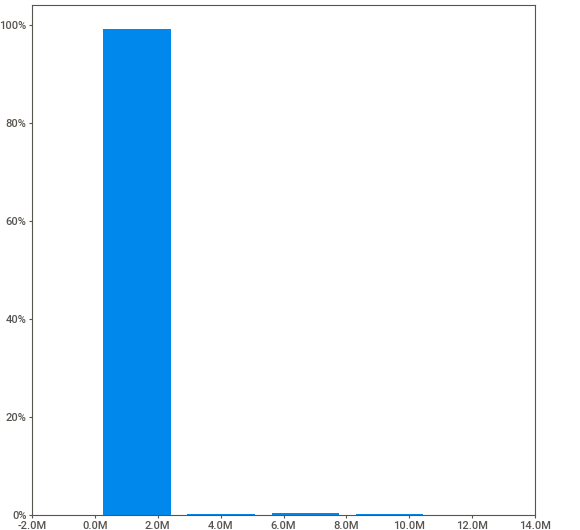
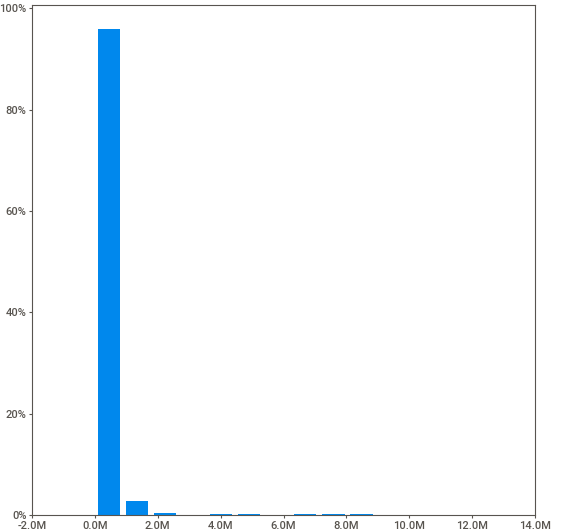
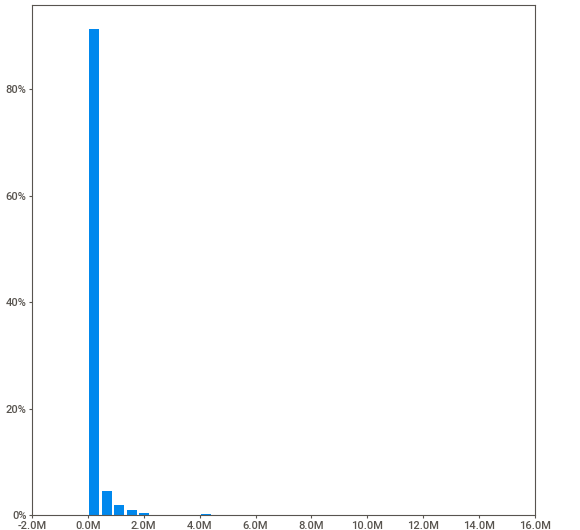
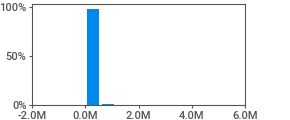
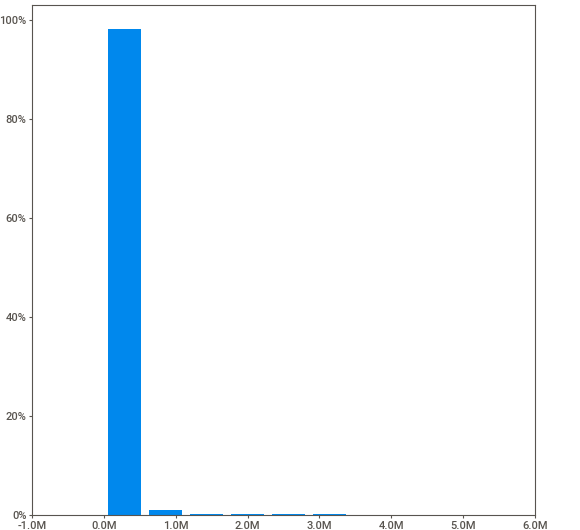
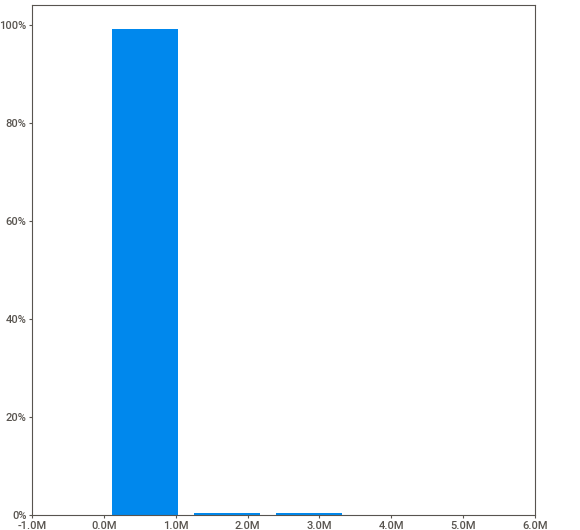
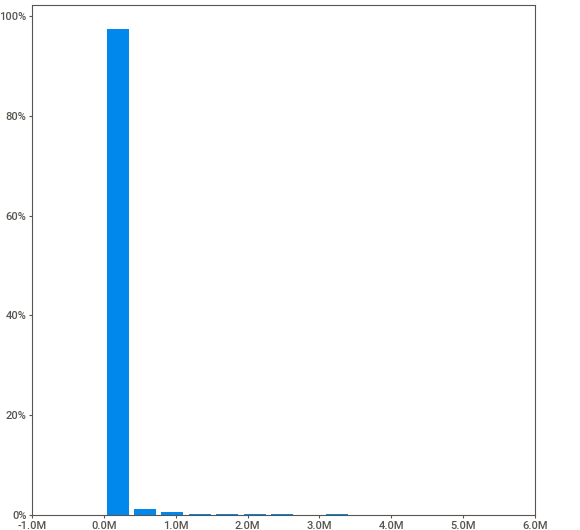
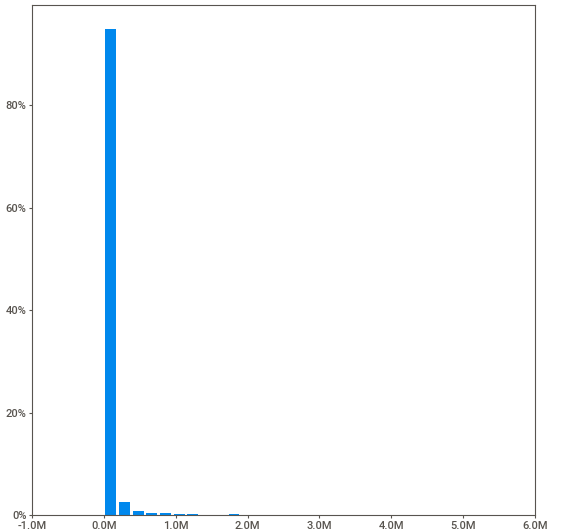
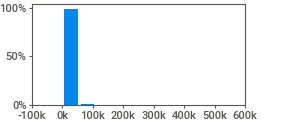
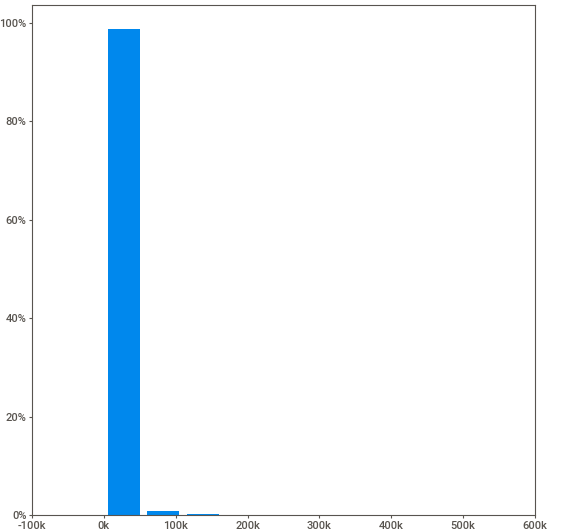
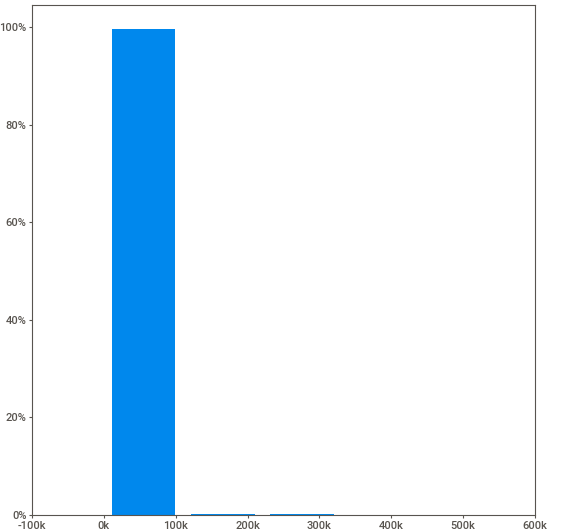
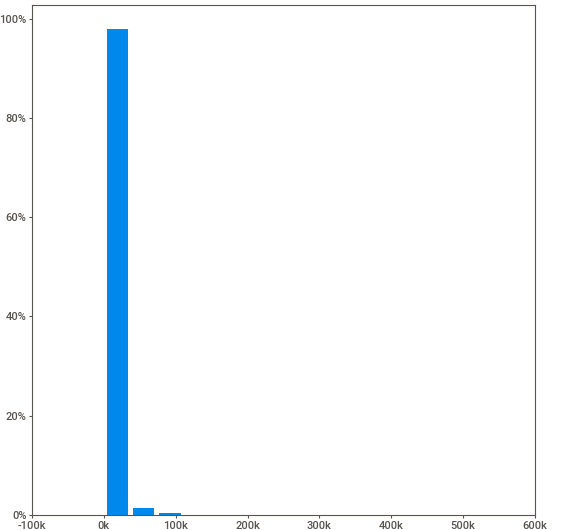
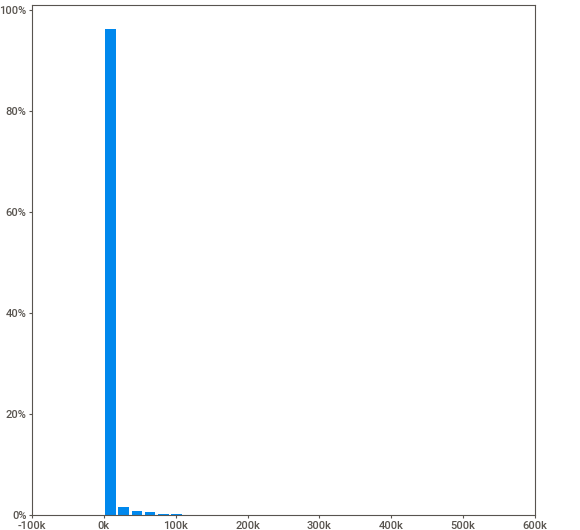
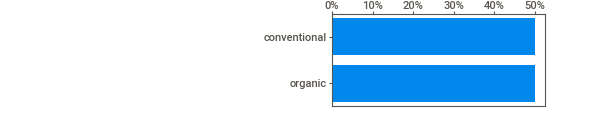
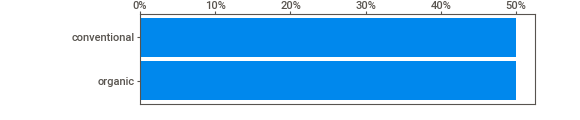
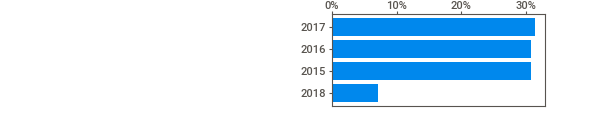
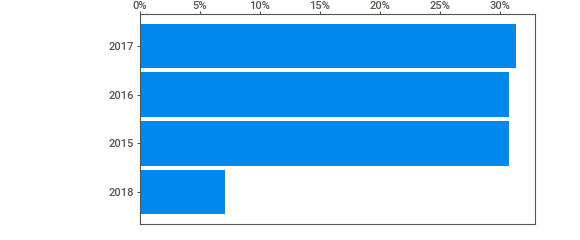
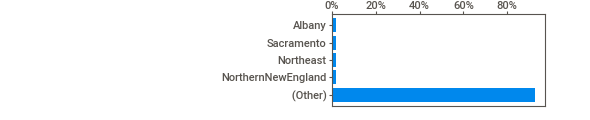
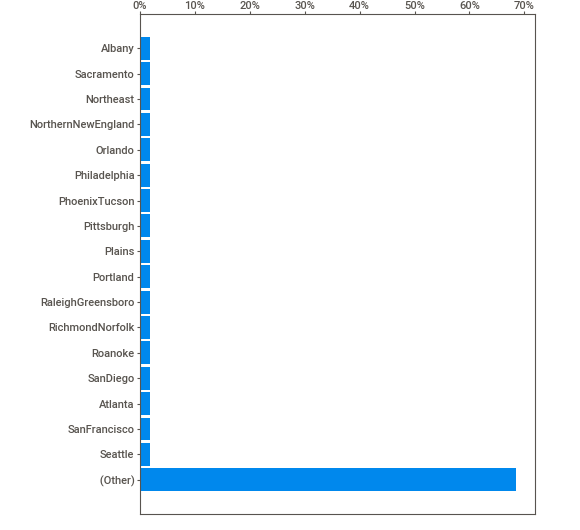
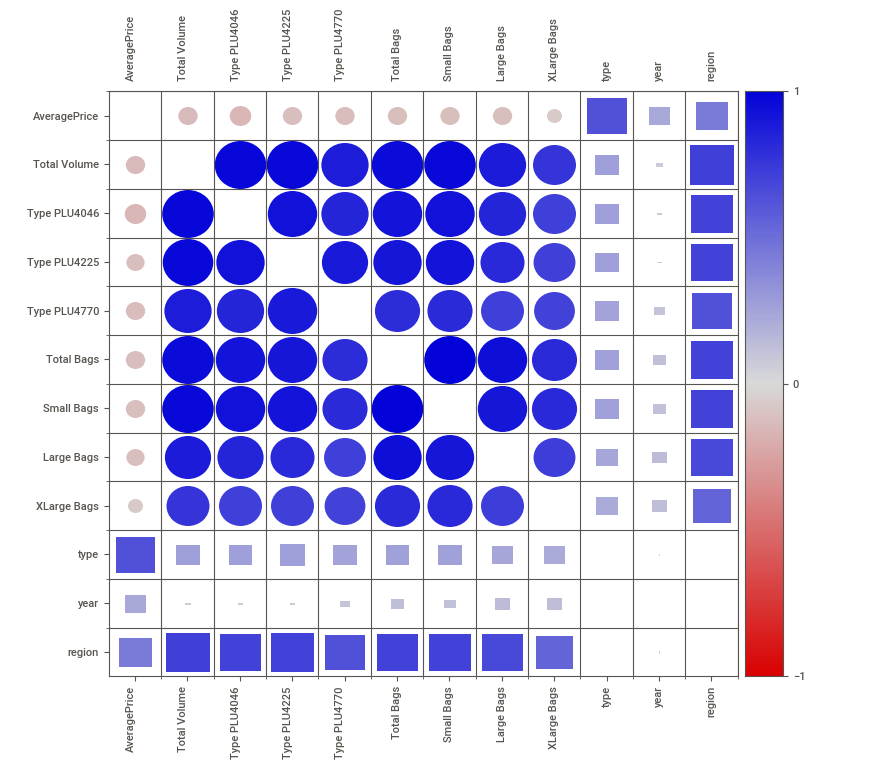
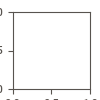

In [15]:
#using SweetViz to create topline visuals to understand the dataset
my_report = sv.analyze(df)
my_report.show_notebook()

<AxesSubplot: xlabel='year', ylabel='AveragePrice'>

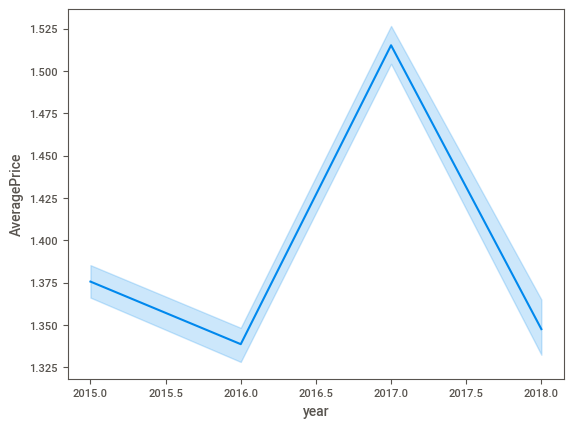

In [16]:
#Plot of the average price over the year for Avocados
sns.lineplot(data=df, x="year", y="AveragePrice")

The Seaborn library plots a mean from the aggregation of multiple y values, creating a line shadow showing the confidence interval.

<AxesSubplot: xlabel='year', ylabel='AveragePrice'>

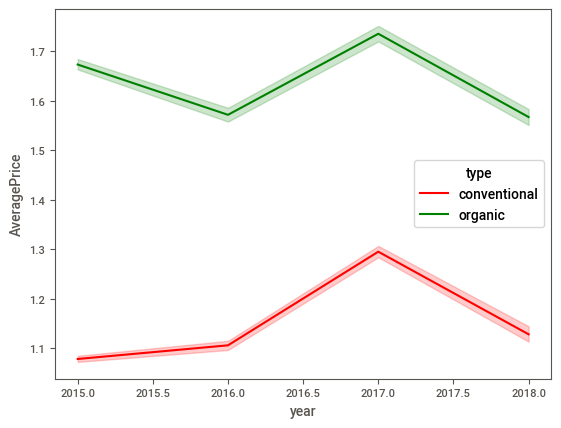

In [17]:
#Plot of the average price over the year for the two types of Avocados
sns.lineplot(data=df, x="year", y="AveragePrice", hue='type', palette=['r', 'g'])

The Average Price of organic avocados is higher than of conventional avocados. Year 2017 is that year where the price is maximum.

<AxesSubplot: xlabel='Month', ylabel='AveragePrice'>

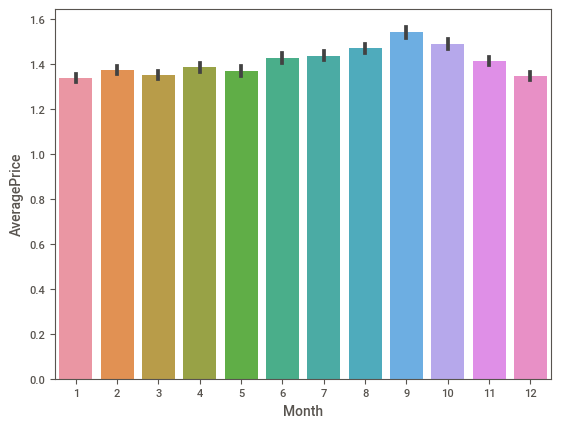

In [18]:
#Plot the average price over the months
sns.barplot(x='Month', y = 'AveragePrice', data =ohe)

In September and October, there is a peak on average price however overall it stays similar. 

<AxesSubplot: xlabel='Day', ylabel='AveragePrice'>

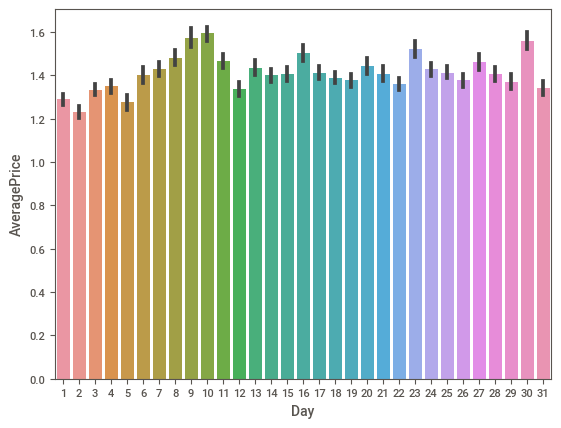

In [19]:
#Plot the average price by day of the month
sns.barplot(x='Day', y = 'AveragePrice', data =ohe)

On the 9th, 10th and 30th of the month the Average Price is higher compared to the 2nd where it is the lowest.

<AxesSubplot: xlabel='year', ylabel='Total Volume'>

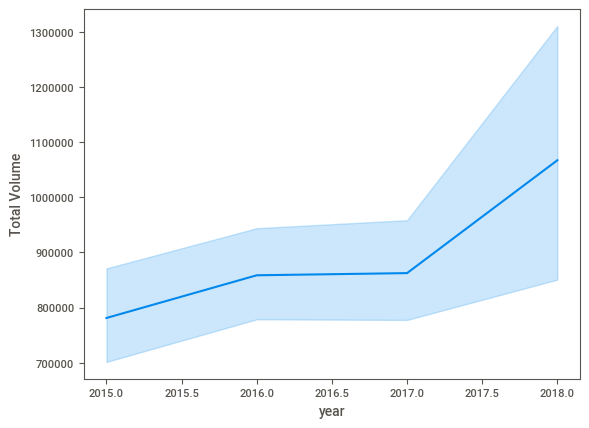

In [20]:
#Plot of the total volume over the year for Avocados
sns.lineplot(data=df, x="year", y="Total Volume")

<AxesSubplot: xlabel='year', ylabel='Total Volume'>

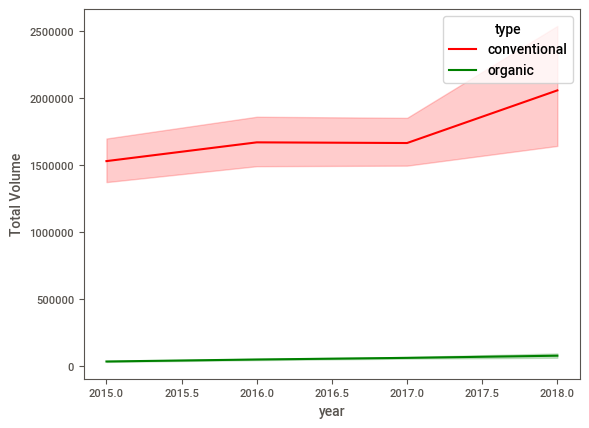

In [21]:
#Plot of the Total Volume over the year for the two types of Avocados
sns.lineplot(data=df, x="year", y="Total Volume", hue='type', palette=['r', 'g'])

<AxesSubplot: xlabel='year', ylabel='AveragePrice'>

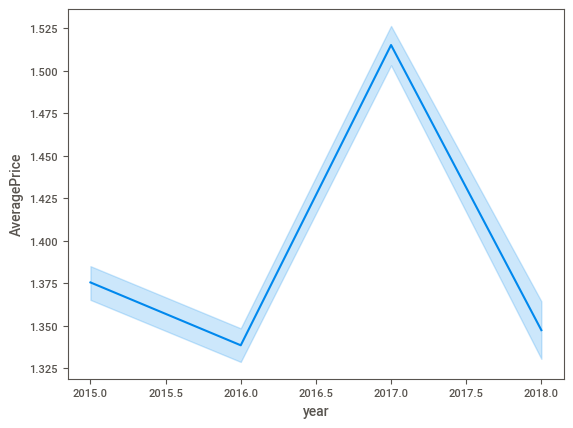

In [22]:
#plot of the total bags over the year for Avocados
sns.lineplot(data=df, x="year", y="AveragePrice")

This follows the same trend as Average Price so, we can assume they are closely correlated.

<AxesSubplot: xlabel='year', ylabel='Total Bags'>

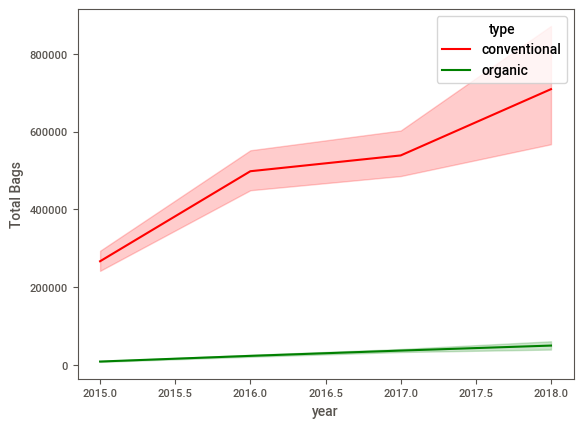

In [23]:
#lot of the Total Bags over the year for the two types of Avocados
sns.lineplot(data=df, x="year", y="Total Bags", hue='type', palette=['r', 'g'])

#### 3.2 Correlation

<AxesSubplot: >

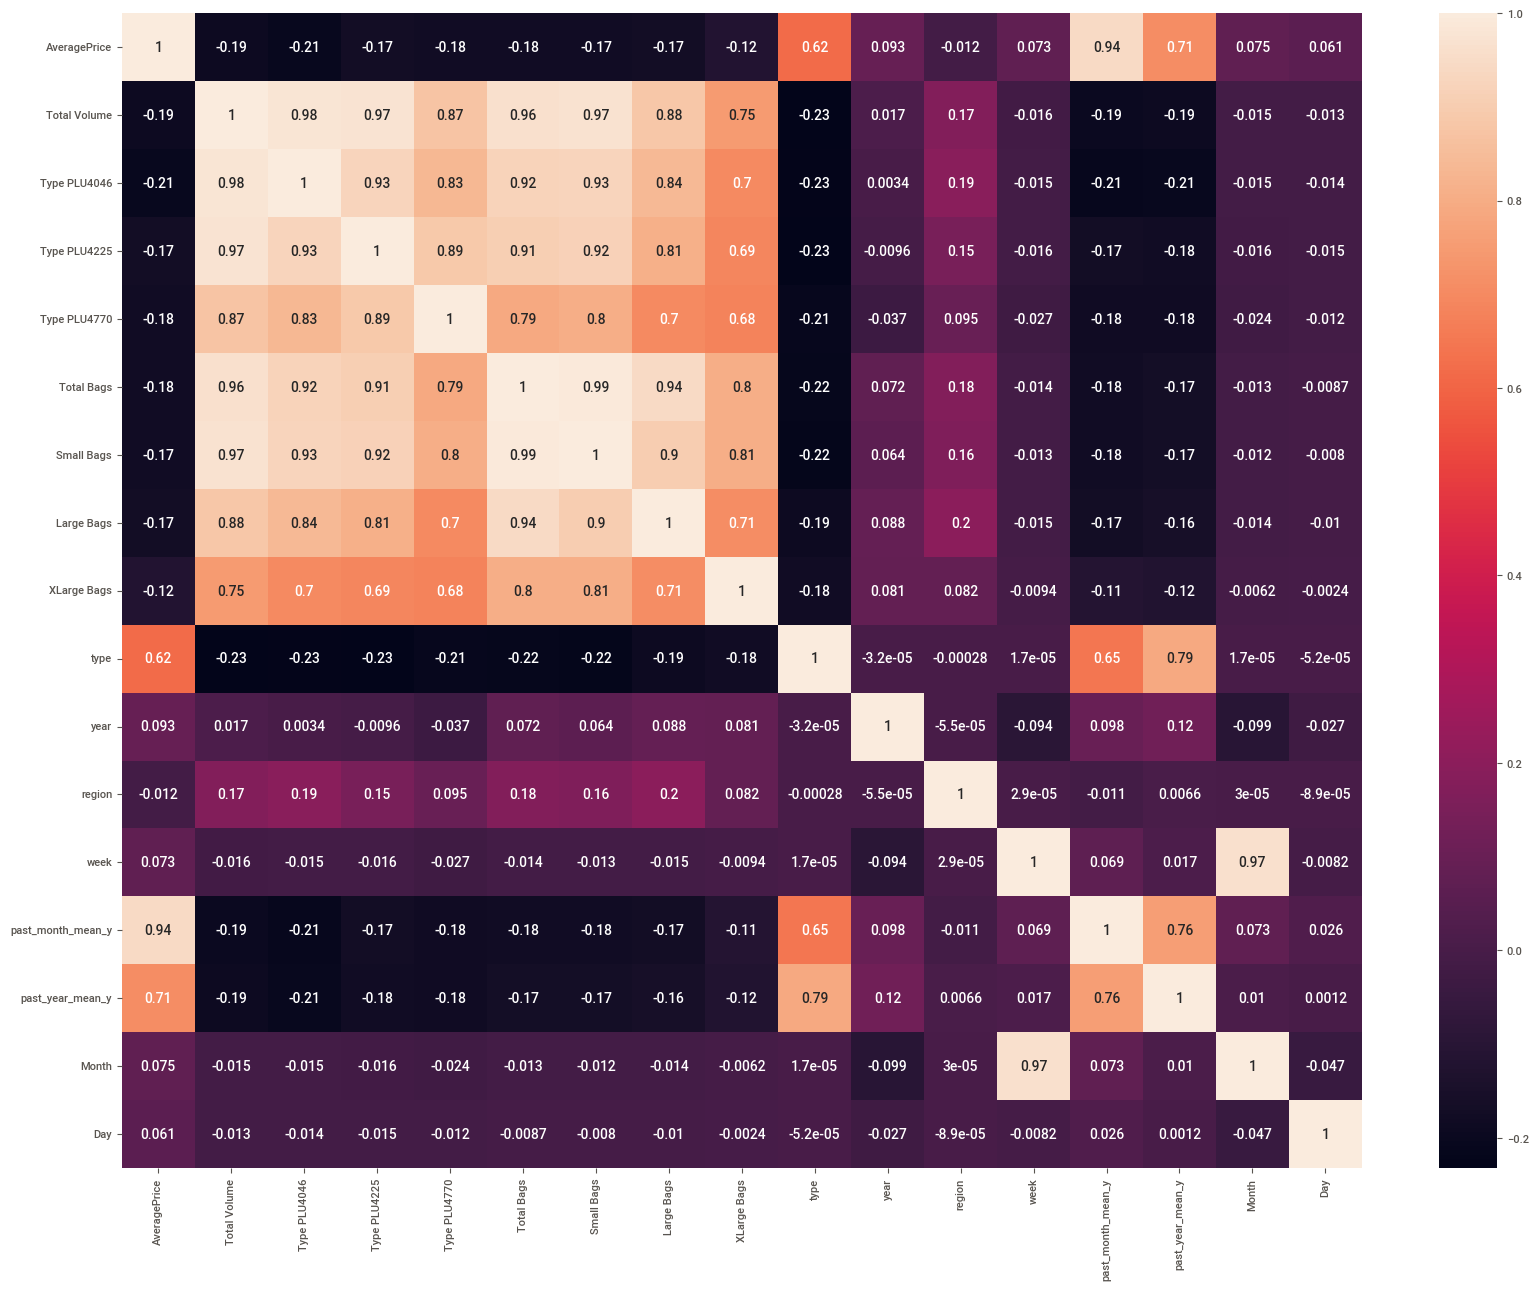

In [24]:
#Visualising the correlation between the dataset's variables
plt.subplots(figsize=(20,15))
sns.heatmap(ohe.corr(), annot=True)

Average price is positively correlated to type of avocado and time realted variables. Bag type and Type PLU categories show negative correlations.

#### Outliers

array([[<AxesSubplot: title={'center': 'AveragePrice'}>,
        <AxesSubplot: title={'center': 'Total Volume'}>,
        <AxesSubplot: title={'center': 'Type PLU4046'}>,
        <AxesSubplot: title={'center': 'Type PLU4225'}>,
        <AxesSubplot: title={'center': 'Type PLU4770'}>,
        <AxesSubplot: title={'center': 'Total Bags'}>,
        <AxesSubplot: title={'center': 'Small Bags'}>,
        <AxesSubplot: title={'center': 'Large Bags'}>,
        <AxesSubplot: title={'center': 'XLarge Bags'}>],
       [<AxesSubplot: title={'center': 'type'}>,
        <AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'region'}>,
        <AxesSubplot: title={'center': 'week'}>,
        <AxesSubplot: title={'center': 'past_month_mean_y'}>,
        <AxesSubplot: title={'center': 'past_year_mean_y'}>,
        <AxesSubplot: title={'center': 'Month'}>,
        <AxesSubplot: title={'center': 'Day'}>, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: 

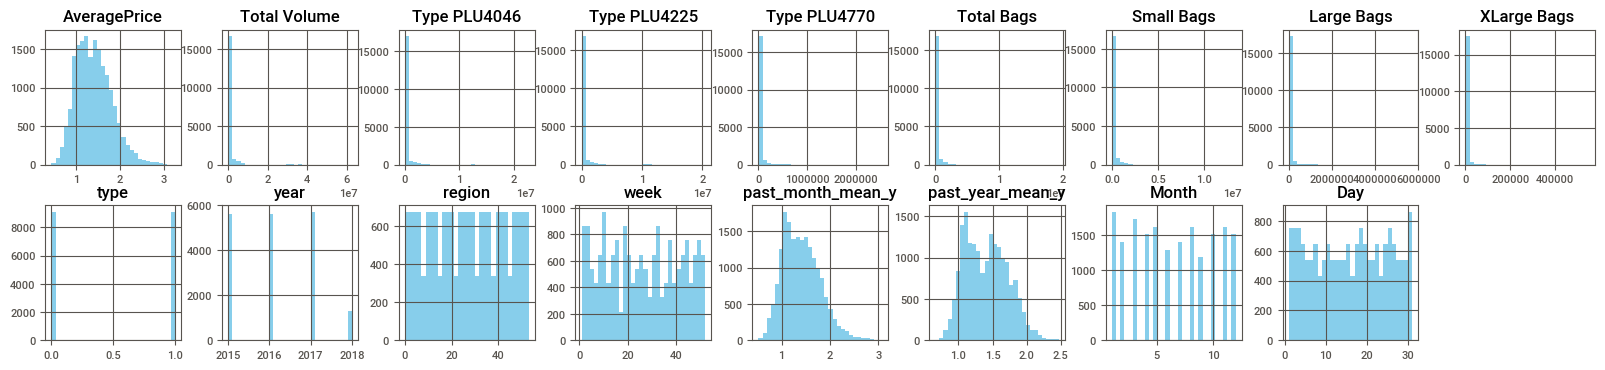

In [25]:
#Plot to show the distribution of dataset variables
ohe.hist(figsize=(20,20), grid = True, layout=(9,9), bins = 30, color='skyblue')

Average price has a normal distribution and the date categories have a good range of data accross the time frame. There are some regions with less data available in comparison to others. 

AveragePrice           AxesSubplot(0.125,0.807358;0.0731132x0.0726415)
Total Volume         AxesSubplot(0.212736,0.807358;0.0731132x0.0726...
Type PLU4046         AxesSubplot(0.300472,0.807358;0.0731132x0.0726...
Type PLU4225         AxesSubplot(0.388208,0.807358;0.0731132x0.0726...
Type PLU4770         AxesSubplot(0.475943,0.807358;0.0731132x0.0726...
Total Bags           AxesSubplot(0.563679,0.807358;0.0731132x0.0726...
Small Bags           AxesSubplot(0.651415,0.807358;0.0731132x0.0726...
Large Bags           AxesSubplot(0.739151,0.807358;0.0731132x0.0726...
XLarge Bags          AxesSubplot(0.826887,0.807358;0.0731132x0.0726...
type                   AxesSubplot(0.125,0.720189;0.0731132x0.0726415)
year                 AxesSubplot(0.212736,0.720189;0.0731132x0.0726...
region               AxesSubplot(0.300472,0.720189;0.0731132x0.0726...
week                 AxesSubplot(0.388208,0.720189;0.0731132x0.0726...
past_month_mean_y    AxesSubplot(0.475943,0.720189;0.0731132x0.0726...
past_y

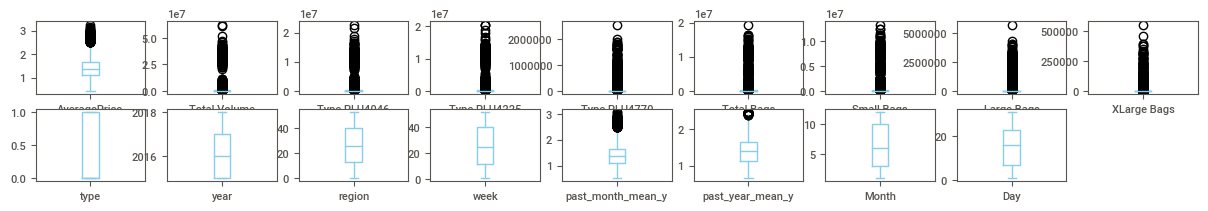

In [26]:
#Boxplots to show outliers accross variables where the black circle represents outliers.
ohe.plot(kind='box', subplots=True, layout=(9,9), figsize=(15,10),color='skyblue')

From the above we can see many outliers represented by the black dots. Zscores (Nkikabahizi, 2022)can be used to replace these with a mean value of Average Prices.

In [27]:
#Calculate Z Score
z = np.abs(zscore(ohe))
z

,AveragePrice,Total Volume,Type PLU4046,Type PLU4225,Type PLU4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,week,past_month_mean_y,past_year_mean_y,Month,Day
0,0.188689,0.227716,0.230816,0.199902,0.212091,0.234170,0.232647,0.222352,0.17558,0.999836,1.221282,1.700252,1.699696,0.608169,0.748126,1.596385,1.283685
1,0.139020,0.230427,0.231103,0.208054,0.211997,0.233350,0.231568,0.222335,0.17558,0.999836,1.221282,1.700252,1.634516,0.608169,0.748126,1.596385,0.504548
2,1.182069,0.212085,0.231007,0.154478,0.211325,0.234730,0.233399,0.222311,0.17558,0.999836,1.221282,1.700252,1.569335,0.608169,0.748126,1.596385,0.274588
3,0.809551,0.223444,0.230741,0.185350,0.211864,0.237096,0.236568,0.222186,0.17558,0.999836,1.221282,1.700252,0.125365,0.608169,0.748126,0.105773,0.385893
4,0.312861,0.231538,0.230891,0.208719,0.211834,0.236718,0.236154,0.221924,0.17558,0.999836,1.221282,1.700252,1.438973,0.640737,0.748126,1.312692,1.506295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.556347,0.241373,0.230017,0.243857,0.212540,0.229301,0.226665,0.220964,0.17558,1.000164,1.970504,1.700811,0.777172,0.460066,0.307011,0.673159,1.498945
8,0.755023,0.242296,0.230693,0.242277,0.212540,0.233594,0.232196,0.221403,0.17558,1.000164,1.970504,1.700811,1.428980,0.551257,0.332280,1.524238,1.394990
9,1.152375,0.242331,0.230693,0.243090,0.205766,0.233463,0.231644,0.222561,0.17558,1.000164,1.970504,1.700811,1.494160,0.753180,0.367410,1.524238,0.615853
10,1.301382,0.241625,0.230428,0.242651,0.205774,0.231866,0.229543,0.222529,0.17558,1.000164,1.970504,1.700811,1.559341,0.987670,0.410552,1.524238,0.163283


In [28]:
#commonly 3 is the threshold that is used 
print(np.where(z<3))
print(ohe.shape)

(array([    0,     0,     0, ..., 18248, 18248, 18248], dtype=int64), array([ 0,  1,  2, ..., 14, 15, 16], dtype=int64))
(18249, 17)


In [29]:
#assign value to new_ohe where value is an outlier
ohe_new = ohe[(z<3).all(axis = 1)]

In [30]:
print(ohe.shape)
print(ohe_new.shape)
ohe = ohe_new
print('Shape after outlier removal:', ohe.shape)

(18249, 17)
(17587, 17)
Shape after outlier removal: (17587, 17)


<AxesSubplot: >

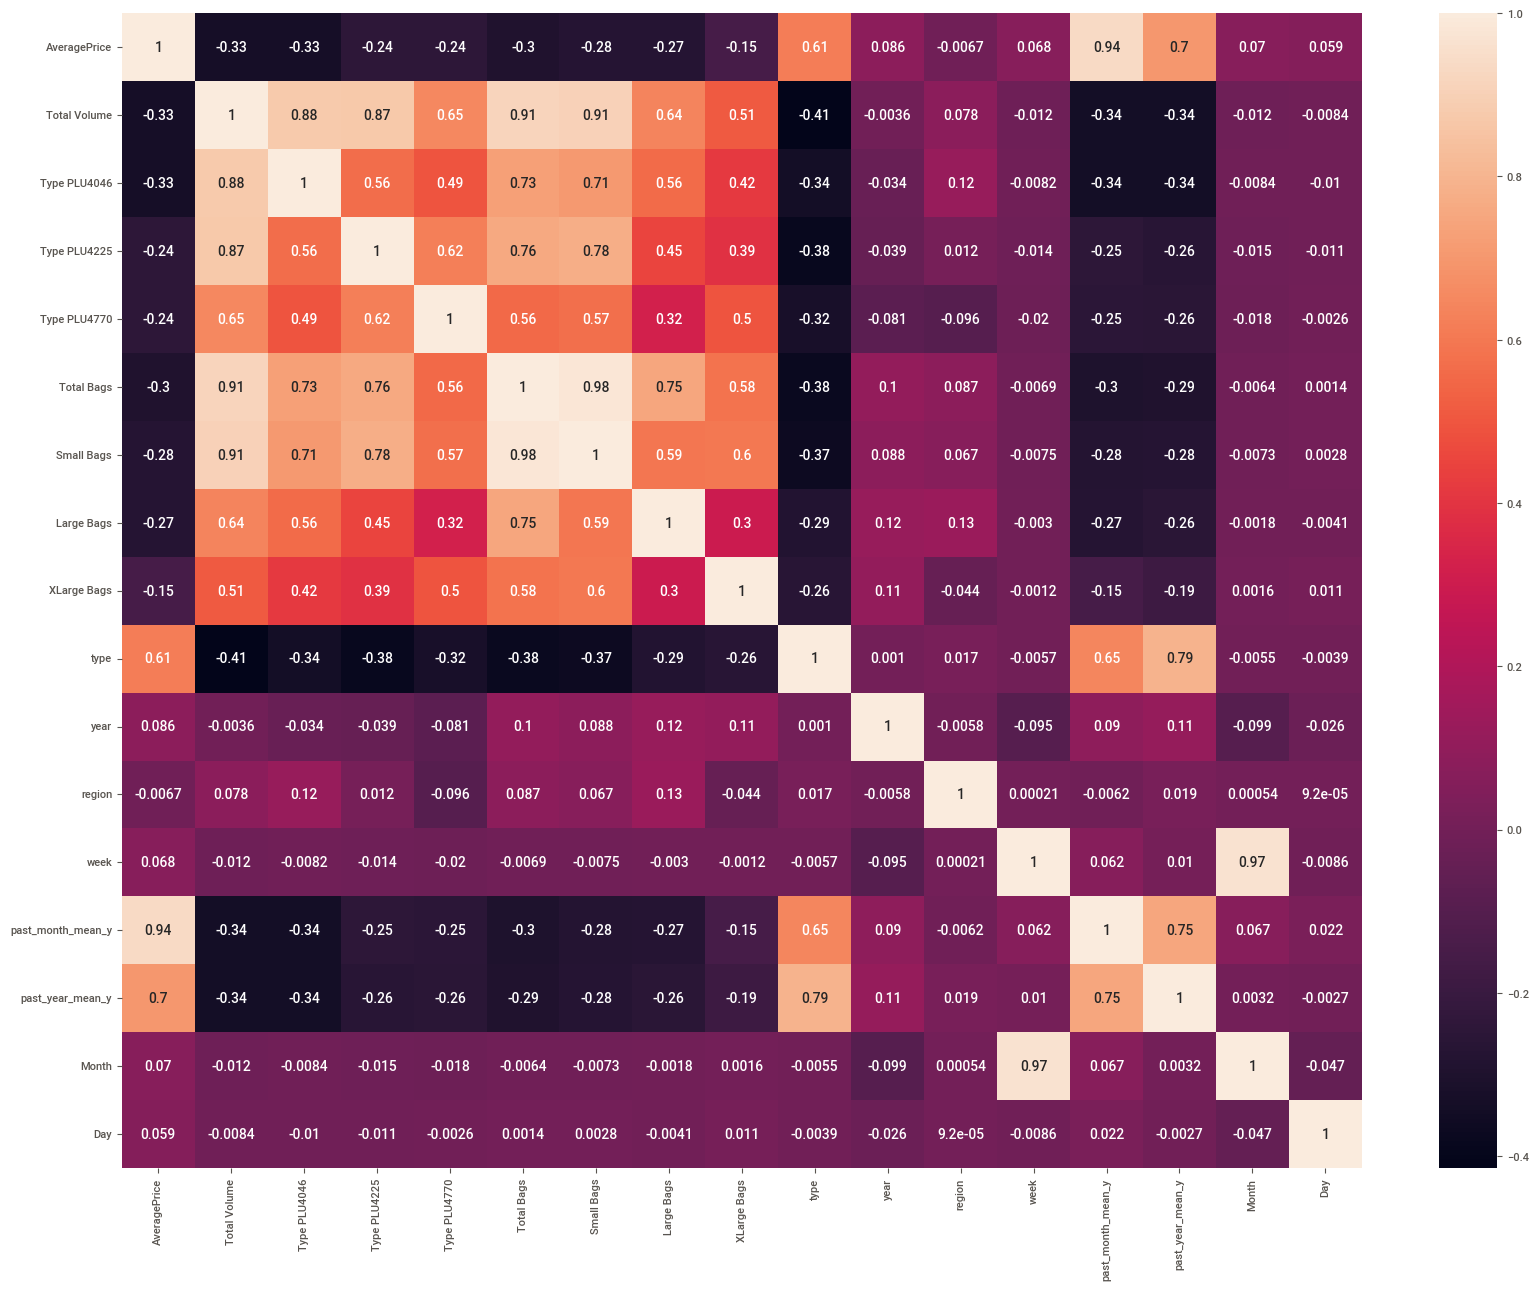

In [31]:
#Correlation after the removal of the outliers
plt.subplots(figsize=(20,15))
sns.heatmap(ohe.corr(), annot =True)

By removing the outliers, the correlation has improved in some areas where there were negative relationships and slightly decreased for those with a positive relationship.

### Ethical Concerns

When building predictive models, we must ensure that we do not introduce bias to models that could lead to discrimination as described in the Equality Act (UK Gov, 2010). In this dataset, there are no concerns as any customer specific data is not used.

## 4. Modelling

In [32]:
#Drop the AveragePrice column for modelling
X= ohe.drop(['AveragePrice'], axis=1)
y = ohe['AveragePrice']

In [33]:
#Split the test and train data for modelling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Scaling

As there are some issues with the range of features, Scaling will be used to support normalising this (Chong, 2020)

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear Regression

Linear regression predicts values based on the value of dependant variables. Categorical variables are needed to be encoded for this model and the independant variable requires a normal distribution as was seen in this dataset (IBM, 2024).

In [35]:
# Creating and training model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Model making a prediction on test data
lm_train_prediction=lm_model.predict(X_train)
lm_test_prediction=lm_model.predict(X_test)

In [36]:
lm_r2_train=metrics.r2_score(lm_train_prediction,y_train)
lm_r2_test=metrics.r2_score(lm_test_prediction,y_test)
lm_mae_train=metrics.mean_absolute_error(lm_train_prediction,y_train)
lm_mae_test=metrics.mean_absolute_error(lm_test_prediction,y_test)
lm_rmse_train=metrics.mean_squared_error(lm_train_prediction,y_train,squared=False)
lm_rmse_test=metrics.mean_squared_error(lm_test_prediction,y_test,squared=False)

print('R2 Train:', lm_r2_train)
print('R2 Test:', lm_r2_test)
print('MAE Train:', lm_mae_train)
print('MAE Test:', lm_mae_test)
print('Root Mean Squared Error Train:', lm_rmse_train)
print('Root Mean Squared Error Train:', lm_rmse_test)

R2 Train: 0.8674354259213698
R2 Test: 0.8713612034142051
MAE Train: 0.09056848751264078
MAE Test: 0.08903151862816197
Root Mean Squared Error Train: 0.13074063796392135
Root Mean Squared Error Train: 0.12937227236614038


To improve this model, OneHotEncoder could have been used, with this dataset it was trialled. However, when the region was split out the zscore was calculated causing all the dataset to be removed. When using LabelEncoder, region was removed as the assignment of the number presents issues but this caused the R2 number to decrease further. 

In [37]:
results = pd.DataFrame({'Actual':y_test, 'Predicted':lm_test_prediction})
results.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
results['Difference'] = results['Actual'] - results['Predicted']
results

,Actual,Predicted,Difference
29,1.67,1.641264,0.028736
20,1.77,1.661207,0.108793
23,2.25,2.224765,0.025235
41,1.10,1.244092,-0.144092
20,1.25,1.201347,0.048653
...,...,...,...
6,1.75,1.737420,0.012580
50,2.06,1.878475,0.181525
19,0.89,1.051289,-0.161289
46,1.43,1.416466,0.013534


<AxesSubplot: xlabel='Actual', ylabel='Predicted'>

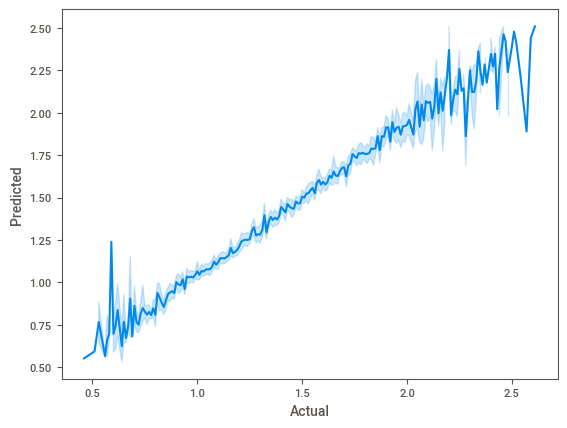

In [38]:
#plot of 
sns.lineplot(data=results, x="Actual", y= 'Predicted')

#### Random Forest

Random Forest is a combination of multiple decision tress to reach a prediction. This was selected as it reduces the risk of overfitting that a Decision Tree model may have. However, it is a longer model to run and much more complex (IBM, 2024).

In [39]:
rf_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [40]:
rf_train_prediction=rf_model.predict(X_train)
rf_test_prediction=rf_model.predict(X_test)

In [41]:
rf_r2_train=metrics.r2_score(rf_train_prediction,y_train)
rf_r2_test=metrics.r2_score(rf_test_prediction,y_test)
rf_mae_train=metrics.mean_absolute_error(rf_train_prediction,y_train)
rf_mae_test=metrics.mean_absolute_error(rf_test_prediction,y_test)
rf_rmse_train=metrics.mean_squared_error(rf_train_prediction,y_train,squared=False)
rf_rmse_test=metrics.mean_squared_error(rf_test_prediction,y_test,squared=False)

print('R2 Train:', rf_r2_train)
print('R2 Test:', rf_r2_test)
print('MAE Train:', rf_mae_train)
print('MAE Test:', rf_mae_test)
print('Root Mean Squared Error Train:', rf_rmse_train)
print('Root Mean Squared Error Train:', rf_rmse_test)

R2 Train: 0.9850839125153364
R2 Test: 0.8858942182428077
MAE Train: 0.0312939199658823
MAE Test: 0.08546276009096086
Root Mean Squared Error Train: 0.04523409360531651
Root Mean Squared Error Train: 0.12261059344868432


In [42]:
rf_results = pd.DataFrame({'Actual':y_test, 'Predicted':rf_test_prediction})
rf_results.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
rf_results['Difference'] = rf_results['Actual'] - rf_results['Predicted']
rf_results

,Actual,Predicted,Difference
29,1.67,1.63718,0.03282
20,1.77,1.68518,0.08482
23,2.25,2.20249,0.04751
41,1.10,1.25396,-0.15396
20,1.25,1.19211,0.05789
...,...,...,...
6,1.75,1.68229,0.06771
50,2.06,1.94461,0.11539
19,0.89,1.06567,-0.17567
46,1.43,1.40251,0.02749


<AxesSubplot: xlabel='Actual', ylabel='Predicted'>

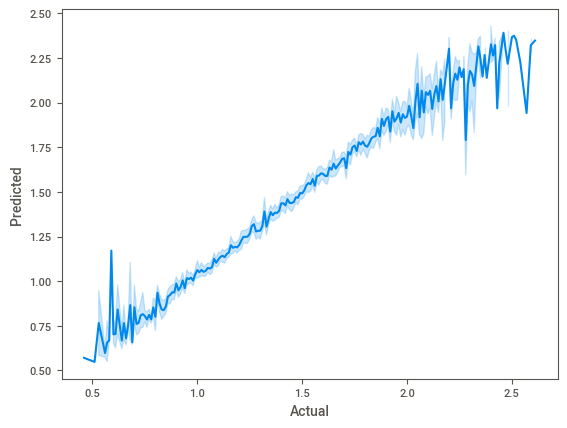

In [43]:
#plot of 
sns.lineplot(data=rf_results, x="Actual", y= 'Predicted')

#### XGBRegressor

XGB Regressor can be used to make predictions on continuous numerical data. Like the Random Forest it ceates a stronger model by combine multiple models. 

In [44]:
xgb_model=XGBRegressor(max_depth=6,n_estimators=1000,learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
xgb_train_prediction=xgb_model.predict(X_train)
xgb_test_prediction=xgb_model.predict(X_test)

In [46]:
xgb_r2_train=metrics.r2_score(xgb_train_prediction,y_train)
xgb_r2_test=metrics.r2_score(xgb_test_prediction,y_test)
xgb_mae_train=metrics.mean_absolute_error(xgb_train_prediction,y_train)
xgb_mae_test=metrics.mean_absolute_error(xgb_test_prediction,y_test)
xgb_rmse_train=metrics.mean_squared_error(xgb_train_prediction,y_train,squared=False)
xgb_rmse_test=metrics.mean_squared_error(xgb_test_prediction,y_test,squared=False)

print('R2 Train:', xgb_r2_train)
print('R2 Test:', xgb_r2_test)
print('MAE Train:', xgb_mae_train)
print('MAE Test:', xgb_mae_test)
print('Root Mean Squared Error Train:', xgb_rmse_train)
print('Root Mean Squared Error Train:', xgb_rmse_test)

R2 Train: 0.9960141504227119
R2 Test: 0.9295731744066595
MAE Train: 0.017607506369551374
MAE Test: 0.06872962663972018
Root Mean Squared Error Train: 0.023886615229435696
Root Mean Squared Error Train: 0.09786600414113462


In [47]:
xgb_results = pd.DataFrame({'Actual':y_test, 'Predicted':xgb_test_prediction})
xgb_results.groupby(["Actual", "Predicted"]).size().reset_index(name="Count")
xgb_results['Difference'] = xgb_results['Actual'] - xgb_results['Predicted']
xgb_results

,Actual,Predicted,Difference
29,1.67,1.676759,-0.006759
20,1.77,1.733038,0.036962
23,2.25,2.254363,-0.004363
41,1.10,1.257970,-0.157970
20,1.25,1.266275,-0.016275
...,...,...,...
6,1.75,1.690822,0.059178
50,2.06,2.029743,0.030257
19,0.89,0.967543,-0.077543
46,1.43,1.445996,-0.015996


<AxesSubplot: xlabel='Actual', ylabel='Predicted'>

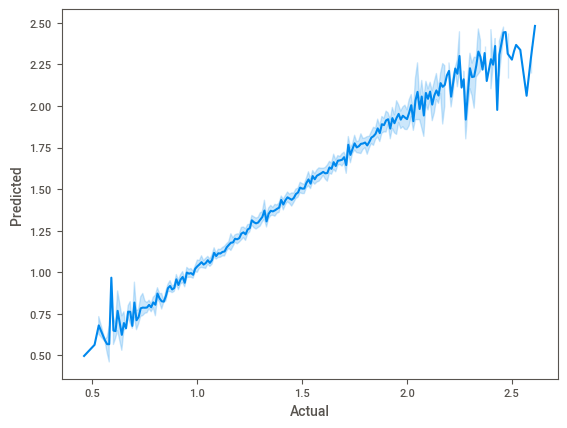

In [48]:
#plot of 
sns.lineplot(data=xgb_results, x="Actual", y= 'Predicted')

### 5. Findings and Recommendations

Across all three models, above an actual price of 2.0 we see variance in the actual and predicted, more in the Linear Regression Model than the other two models. This can also be see near a price of 0.50.

With the Random Forest and XGB Regressor model, the R2 scores do raise some concern as the high scores in using the training sets show some overfitting and we see that R2 scores do reduce with the test data which is positive as we would hope to see that. With the Linear Regression Model, by adding the mean price by month and year this helped improve the R2 score from negative to above 80%.

The dataset had various outliers and it is recommended that a further investigation into these would be beneficial. In terms of completeness, the data lacked information around what the relationship between bag size and volume of sold avocados were. There was limited information about the dataset in the brief, so assumptions were needed. 

The dataset had little duplicate values and was unique however as average pricing was used, this may affect the integrity of the dataset as we cannot trace back the single transaction in the grouped average. In the future, all the individual transactions could be monitored, and these could be inputted into the above models. Without the average it will be better to understand the impact of the variables and this would create more datapoints where a Neural Network would work better.

Location had a negative impact on the model so, it would be good to introduce more accurate location data to the dataset. Also, variables linking to time had a positive correlation so it would be interesting expand the analysis to include times of the day to see what trends this would create. 

Type of Avocado had the strongest correlation to the average price and the price varied widely across the two types. A further analysis and model could be created separating out the types to see the impact it has on the prediction.



### References

Chong, J. (2020). What is Feature Scaling & Why is it Important in Machine Learning?. [Online]. Towards Data Science. Last Updated: 30 December 2020. Available at: https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854a [Accessed 7 January 2024].

Nkikabahizi, C., Cheruiyot, W. and Kibe, A. (2022) ‘Chaining Zscore and feature scaling methods to improve neural networks for classification’, Applied Soft Computing Journal, 123. doi:10.1016/j.asoc.2022.108908.

IBM. (2024). What is linear regression?. [Online]. IBM. Available at: https://www.ibm.com/topics/linear-regression [Accessed 9 January 2024].

IBM. (2024). What is random forest?. [Online]. IBM. Available at: https://www.ibm.com/topics/random-forest [Accessed 9 January 2024].

Schröer, C. Kruse, F. Gómez, J. (2021). A Systematic Literature Review on Applying CRISP-DM Process Model. Procedia Computer Science. 181(2021), pp.526-534. [Online]. Available at: https://doi.org/10.1016/j.procs.2021.01.199 [Accessed 21 December 2023].

Varghese, D. (2018). Comparative Study on Classic Machine learning Algorithms. [Online]. Towards Data Science. Last Updated: 6 December 2018. Available at: https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222 [Accessed 7 January 2024].

Yogi, M. (2020). Implementing Machine Learning on Avocado Data Set. [Online]. Medium. Last Updated: 9 July 2020. Available at: https://medium.com/analytics-vidhya/implementing-machine-learning-on-avocado-data-set-7217943cd7fd [Accessed 7 January 2024].